In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 

import json 
import os 
from mlca_for_elec.env.env import HouseHold, Microgrid
from mlca_for_elec.mlca_elec.mlca import mlca_mechanism


Class NN_MIP_TORCH imported
Class MLCA_WDP imported
Class MLCA_Economies imported
FUNCTION MLCA imported


In [3]:
os.getcwd()
os.chdir("c:\\Users\\pieples\\Documents\\MLICA-for-elec\\")

In [4]:
exp_number = 1

In [5]:
household_path = f"config\experiment{exp_number}\households"
microgrid_path = f"config\experiment{exp_number}\microgrid\exp{exp_number}_microgrid.json"
dataset_path = f"config\experiment{exp_number}\dataset"

# Setup

In [6]:
%matplotlib inline
print("Start loading household profiles")
folder_path = household_path
houses = []

microgrid_1 =json.load(open( microgrid_path))


for file in os.listdir(folder_path)[:5]:
    if file.endswith(".json"):
        household = json.load(open(folder_path+"/"+ file))
    house = HouseHold(household, microgrid_1["horizon"])

    generation_path = "data\solar_prod\Timeseries_55.672_12.592_SA2_1kWp_CdTe_14_44deg_-7deg_2020_2020.csv"
    consumption_path = f"data/consumption/Reference-{house.param['consumption']['type']}.csv"
    spot_price_path = "data/spot_price/2020.csv"
    fcr_price_path = "data/fcr_price/random_fcr.csv"
    profile_path_train = dataset_path + f"/dataset_{house.ID}.csv"
    profile_path_valtest = dataset_path + f"/test_dataset_{house.ID}.csv"
    house.load_data(generation_path,consumption_path, spot_price_path,fcr_price_path, profile_path_train, profile_path_valtest,type = float)
    for i in range(1):
        house.next_data()
    houses.append(house)
print(f"Loaded {len(houses)} households")
print("Start compute social welfare")
print(list(houses[0].data['consumption'].to_numpy()))

MG = Microgrid(houses, microgrid_1)
optimal_allocation = {}
for house in MG.households:
    print(house.data['consumption'].sum())
    optimal_allocation_tuple = MG.get_efficient_allocation()
    optimal_allocation[house.ID] = (optimal_allocation_tuple[0][house.ID] , MG.calculate_value(house.ID, optimal_allocation_tuple[0][house.ID]))


Start loading household profiles
0


1
2
Loaded 3 households
Start compute social welfare
[3.933410972346981, 3.5573139975401666, 2.473751205245027, 1.7327868717820054, 0.9368164524287159, 0.8958949698459905]
13.529974469188886
          0         1         2  external_import
0  2.133178  3.933411  3.933411        10.000000
1  2.885372  3.557314  3.557314        10.000000
2  2.473751  2.473751  2.473751         7.421254
3  1.732787  1.732787  1.732787         5.198361
4  0.936816  0.936816  0.936816         2.810449
5  0.895895  0.895895  0.895895         2.687685 5.560551513781049
13.529974469188886
          0         1         2  external_import
0  2.133178  3.933411  3.933411        10.000000
1  2.885372  3.557314  3.557314        10.000000
2  2.473751  2.473751  2.473751         7.421254
3  1.732787  1.732787  1.732787         5.198361
4  0.936816  0.936816  0.936816         2.810449
5  0.895895  0.895895  0.895895         2.687685 5.560551513781049
13.529974469188886
          0         1         2  external_import


# MG life signal 

In [7]:
print(f"Number of households: {len(MG.households)}")    

Number of households: 3


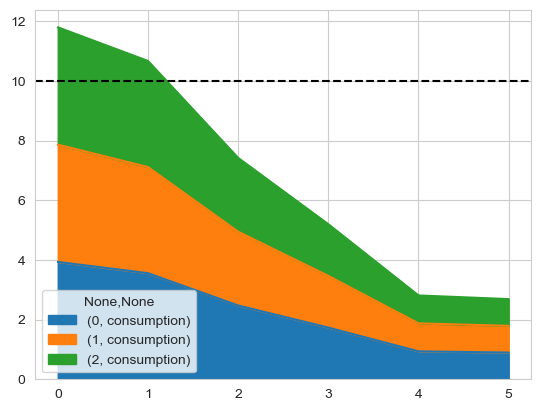

In [8]:
MG.data.loc[:,(slice(None), 'consumption')].plot(kind = "area")
plt.axhline(MG.grid_connection, color = "black", linestyle = "--")

          0         1         2  external_import
0  2.133178  3.933411  3.933411        10.000000
1  2.885372  3.557314  3.557314        10.000000
2  2.473751  2.473751  2.473751         7.421254
3  1.732787  1.732787  1.732787         5.198361
4  0.936816  0.936816  0.936816         2.810449
5  0.895895  0.895895  0.895895         2.687685 5.560551513781049


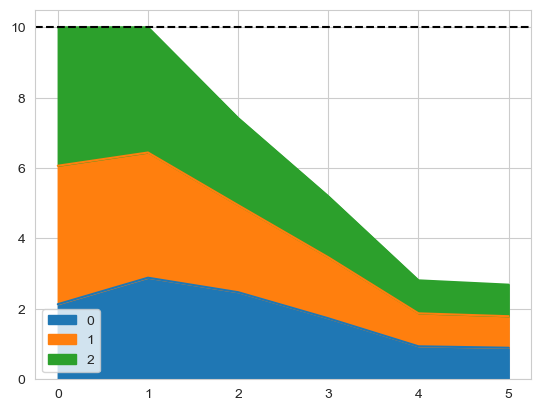

In [9]:
MG.get_efficient_allocation()[0].drop(columns = "external_import").plot(kind="area")
plt.axhline(MG.grid_connection, color = "black", linestyle = "--")


# Results 

In [162]:
# load data 

experiment = 1
res_path = "results"

data_res = {}
for file in os.listdir(res_path):
    if file.endswith(".json"):
        json_file = json.load(open(res_path + "/" + file))

        exp = file.split("_")[1]
        seed = int(file.split("_")[3])
        qinit = int(file.split("_")[5])
        layer = file.split("_")[7]
        if qinit not in data_res.keys():
            data_res[qinit] = {}
        
        data_res[qinit][seed] = json_file["Statistics"]["Efficiency per Iteration"]
        

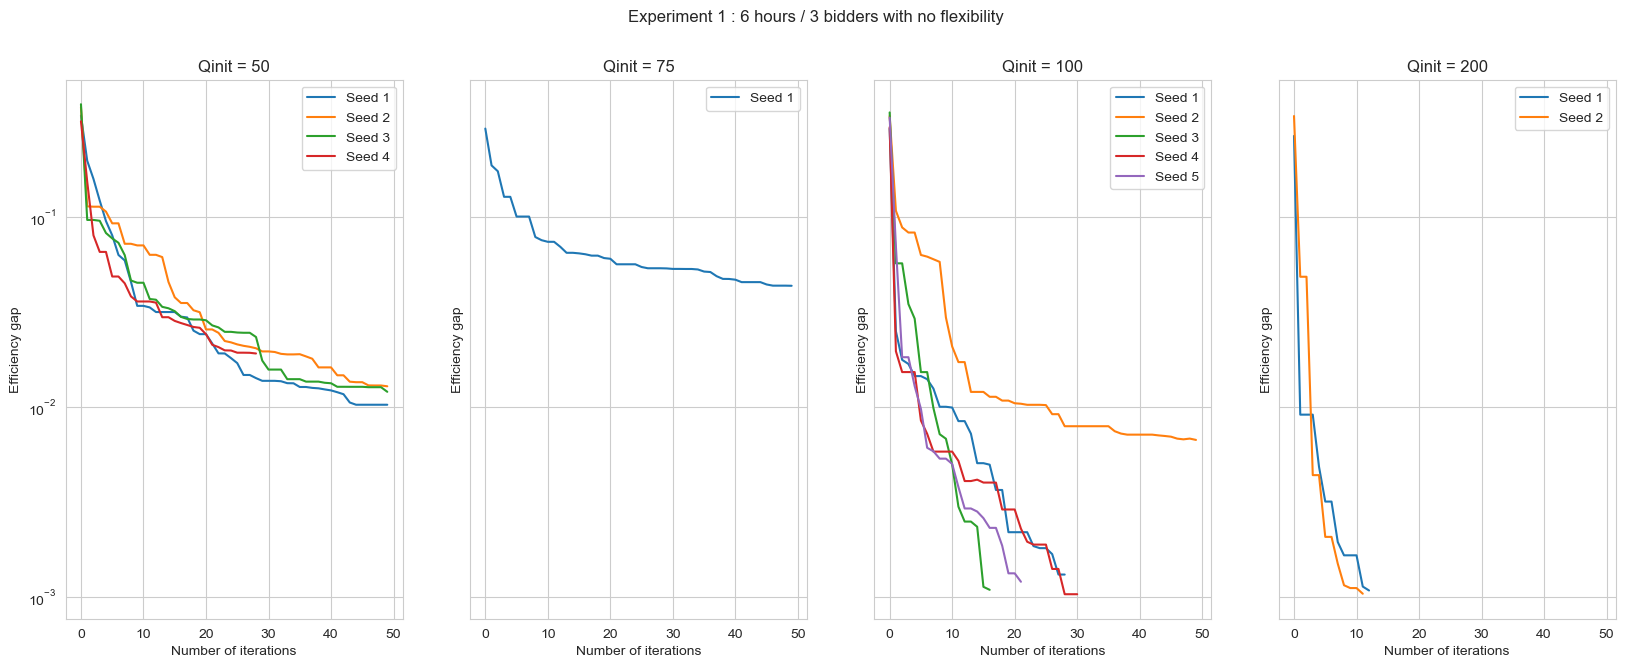

In [163]:
n_qinit = len(data_res.keys())
n_lines =1
n_col = n_qinit//n_lines 

fig, ax = plt.subplots(n_lines, n_col, figsize = (20,7), sharey=True, sharex = True)

for i, key in enumerate(sorted(data_res.keys())):
    for seed in data_res[key].keys():   
        ax[i].semilogy([1-i for i in data_res[key][seed].values()], label =f"Seed {seed}")
        ax[i].set_title(f"Qinit = {key}")
        ax[i].set_xlabel("Number of iterations")
        ax[i].set_ylabel("Efficiency gap")
        ax[i].legend()

plt.suptitle("Experiment 1 : 6 hours / 3 bidders with no flexibility")
plt.show()

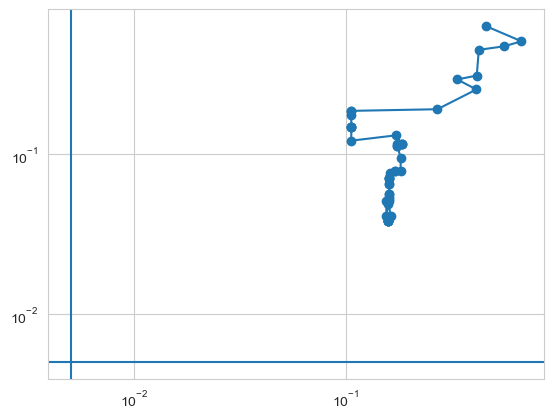

In [182]:
from sklearn.metrics import mean_absolute_error

%matplotlib inline 

path = "results\Exp_1_seed_1_Qinit_50_Qround_1_layer_CALayerReLUProjected.json"
exp = path.split("_")[1]
seed = int(path.split("_")[3])
qinit = int(path.split("_")[5])
layer = path.split("_")[7]
json_file = json.load(open(path))



optimal_allocation_x = optimal_allocation[0][0].to_numpy()
optimal_allocation_y = optimal_allocation[1][0].to_numpy()
optimal_allocation_z = optimal_allocation[2][0].to_numpy()

initial_bids_x = json_file["Elicited Bids"]["Bidder_0"][0]
initial_bids_y = json_file["Elicited Bids"]["Bidder_1"][0]
initial_bids_z = json_file["Elicited Bids"]["Bidder_2"][0]




# plt.hist(list(map(lambda x : mean_absolute_error(optimal_allocation_x,x), initial_bids_x)))
# plt.hist(list(map(lambda y : mean_absolute_error(optimal_allocation_y,y), initial_bids_y)))
# plt.show()

eff_all_per_it = json_file["Statistics"]["Efficient Allocation per Iteration"]

Err_x = []
Err_y = []
Err_z = []
for it in eff_all_per_it.keys():
    
    x = eff_all_per_it[it]["Bidder_0"]["good_ids"]
    y = eff_all_per_it[it]["Bidder_1"]["good_ids"]
    z = eff_all_per_it[it]["Bidder_2"]["good_ids"]
    if len(x) != 0:
        err_x = mean_absolute_error(optimal_allocation_x, x)
        err_y = mean_absolute_error(optimal_allocation_y, y)
        err_z = mean_absolute_error(optimal_allocation_z, z)
        Err_x.append(err_x)
        Err_y.append(err_y)
        Err_z.append(err_z)

plt.loglog(Err_x, Err_y,"-o", label = "Bidder 0")
plt.axvline(0.005)
plt.axhline(0.005)

In [183]:
%matplotlib qt

ax = plt.figure().add_subplot(projection='3d')
ax.scatter(Err_x,Err_y,Err_z, c = [i for i in range(len(Err_z))])
ax.plot(Err_x,Err_y,Err_z, linestyle = "--", linewidth = 0.5)
ax.set_xlabel("MAE Bidder 0")
ax.set_ylabel("MAE Bidder 1")
ax.set_zlabel("MAE Bidder 2")

Text(0.5, 0, 'Err Bidder 2')